<img src=https://upload.wikimedia.org/wikipedia/commons/6/68/Logo_universidad_icesi.svg width=300>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebastianb92/nlp-labs/blob/main/Session1/2-Sentiment-Analysis.ipynb)


# Maestría en Inteligencia Artificial  
## Procesamiento de Lenguaje natural
### Sesión 1 - Practica

---


**Integrantes:**  
- Johan Sebastian Bonilla  
- Edwin Gómez  

# Introducción

Este notebook utiliza [Ultralytics](https://docs.ultralytics.com/) para entrenar modelos de detección de objetos YOLO11 con un conjunto de datos personalizado. Al finalizar este Colab, tendremos un modelo YOLO entrenado específicamente para la detección de armas.

**Configurar entorno**

In [9]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipython-input-2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [10]:
!test '{IN_COLAB}' = 'True' && wget https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/main/requirements.txt && pip install -r requirements.txt

--2026-02-21 03:14:43--  https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     367  --.-KB/s    in 0s      

2026-02-21 03:14:43 (2.58 MB/s) - ‘requirements.txt’ saved [367/367]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!test '{IN_COLAB}' = 'True' && wget https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/feature/session1/sentiment-analysis/Session1/political_analysis.txt

In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

In [7]:
with open('political_analysis.txt', 'r', encoding='utf-8') as file:
    content = file.read()

# Regex pattern to match the format: [HH:MM AM/PM, MM/DD/YYYY] Nombre: Mensaje
pattern = r'\[(\d{1,2}:\d{2}\s[AP]M),\s(\d{1,2}/\d{1,2}/\d{4})\]\s(\w+):\s'

# Find all matches with their positions
matches = list(re.finditer(pattern, content))

# Extract data
data = []
for i, match in enumerate(matches):
    time = match.group(1)
    date = match.group(2)
    name = match.group(3)

    # Get message content (from end of current match to start of next match or end of file)
    start_pos = match.end()
    end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(content)
    message = content[start_pos:end_pos].strip()

    data.append({
        'time': time,
        'date': date,
        'name': name,
        'message': message
    })

# Create DataFrame
df = pd.DataFrame(data)

# Display the dataset
print(f"Total messages: {len(df)}")
print(f"Participants: {df['name'].unique()}")
df.head(10)

Total messages: 84
Participants: ['Pedro' 'María' 'Fernando' 'Carlos' 'Nelson' 'Patricio']


,time,date,name,message
0,11:24 AM,2/17/2026,Pedro,Que par de Joyitas son Petro y el ministro de ...
1,11:24 AM,2/17/2026,Pedro,Son unos Barbaros
2,11:29 AM,2/17/2026,Pedro,Que lo diga alguien que votó y celebró el triu...
3,11:39 AM,2/17/2026,María,Me encantan las fuentes de documentación de lo...
4,11:40 AM,2/17/2026,Fernando,"Que lo diga petro , pero que lo diga el minist..."
5,11:44 AM,2/17/2026,Pedro,El duo de la Muerte culparon a la Señora Madre...
6,11:44 AM,2/17/2026,Pedro,"Pues el no murió por la caida en Bicicleta, Mu..."
7,11:45 AM,2/17/2026,Pedro,"Kevin, un niño de 7 años"
8,11:45 AM,2/17/2026,Pedro,"No son fuentes de documentación y pacotilla, s..."
9,11:59 AM,2/17/2026,María,"querido Pedro, la indignación debería sentirla..."


In [30]:
import nltk
nltk.download('stopwords')  #Son palabras que aportan poco significado al análisis
nltk.download('punkt')      #Tokenizadores: identifican frases con base en patrones: puntuación, abreviaciones, mayúsculas.
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Get Spanish stopwords
stop_words = set(stopwords.words('spanish'))
stop_words.add("si")

# Tokenize and filter all messages
all_words = []
for msg in df['message']:
    tokens = word_tokenize(msg.lower())
    filtered = [w for w in tokens if w.isalpha() and w not in stop_words]
    all_words.extend(filtered)

# Word frequency analysis
freq_dist = FreqDist(all_words)
freq_dist.most_common(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[('gobierno', 17),
 ('millones', 15),
 ('fotógrafo', 13),
 ('petro', 12),
 ('bien', 11),
 ('fuentes', 10),
 ('usted', 10),
 ('rtvc', 10),
 ('https', 9),
 ('ahora', 8),
 ('bueno', 8),
 ('maquillador', 8),
 ('pues', 7),
 ('semana', 7),
 ('ignorancia', 7),
 ('decir', 6),
 ('meses', 6),
 ('sino', 6),
 ('gobiernos', 6),
 ('ahí', 6)]

In [31]:
print(stop_words)

{'nuestros', 'vuestros', 'tuvieron', 'sí', 'tuviese', 'hubieras', 'tenidos', 'eran', 'fuerais', 'estuviera', 'eres', 'hubierais', 'estemos', 'habré', 'teniendo', 'estos', 'tenida', 'hubieron', 'tuviésemos', 'mías', 'tendremos', 'tuyo', 'eras', 'al', 'tenéis', 'son', 'tenido', 'soy', 'estabas', 'han', 'de', 'todo', 'donde', 'yo', 'tendréis', 'en', 'sus', 'las', 'estuviste', 'quien', 'haya', 'estaríais', 'por', 'ellas', 'estáis', 'nuestro', 'esa', 'habrán', 'hayas', 'habían', 'tengan', 'fuisteis', 'fuesen', 'hubiésemos', 'fuéramos', 'contra', 'tenidas', 'tuvieran', 'antes', 'entre', 'ti', 'ni', 'nos', 'hubimos', 'sentidas', 'tuve', 'estoy', 'tu', 'hubo', 'e', 'suya', 'somos', 'serían', 'estuve', 'era', 'algo', 'serías', 'he', 'hay', 'sean', 'seremos', 'tendrán', 'estados', 'mucho', 'habréis', 'a', 'hubiesen', 'hubisteis', 'seamos', 'otras', 'muchos', 'estuvimos', 'cual', 'nada', 'fue', 'habida', 'tened', 'tuvisteis', 'algunos', 'estaríamos', 'hubiera', 'sería', 'estuvieses', 'fueses', 'e

## Frecuencia de palabras por participante

In [32]:
for participant in df['name'].unique():
    participant_messages = df[df['name'] == participant]['message'].str.cat(sep=' ')
    tokens = word_tokenize(participant_messages.lower())
    filtered_words = [w for w in tokens if w.isalpha() and w not in stop_words]
    freq_dist_participant = FreqDist(filtered_words)
    print(f"\nTop 5 most frequent words for {participant}:")
    print(freq_dist_participant.most_common(5))


Top 5 most frequent words for Pedro:
[('ministro', 2), ('bicicleta', 2), ('murió', 2), ('par', 1), ('joyitas', 1)]

Top 5 most frequent words for María:
[('fuentes', 4), ('millones', 4), ('indignación', 3), ('gobierno', 3), ('fotógrafo', 3)]

Top 5 most frequent words for Fernando:
[('diga', 3), ('ocurría', 3), ('mario', 2), ('riñón', 2), ('gobiernos', 2)]

Top 5 most frequent words for Carlos:
[('gobierno', 9), ('millones', 8), ('fotógrafo', 6), ('https', 5), ('petro', 5)]

Top 5 most frequent words for Nelson:
[('ignorancia', 5), ('bajeza', 3), ('colombia', 3), ('igual', 3), ('pib', 3)]

Top 5 most frequent words for Patricio:
[('usted', 5), ('veces', 5), ('gobierno', 4), ('rtvc', 4), ('ahí', 4)]


## Palabras más comunes por participante


In [37]:
participant_top_words = {}

for participant in df['name'].unique():
    participant_messages = df[df['name'] == participant]['message'].str.cat(sep=' ')
    tokens = word_tokenize(participant_messages.lower())
    filtered_words = [w for w in tokens if w.isalpha() and w not in stop_words]
    freq_dist_participant = FreqDist(filtered_words)
    participant_top_words[participant] = freq_dist_participant.most_common(5)


/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

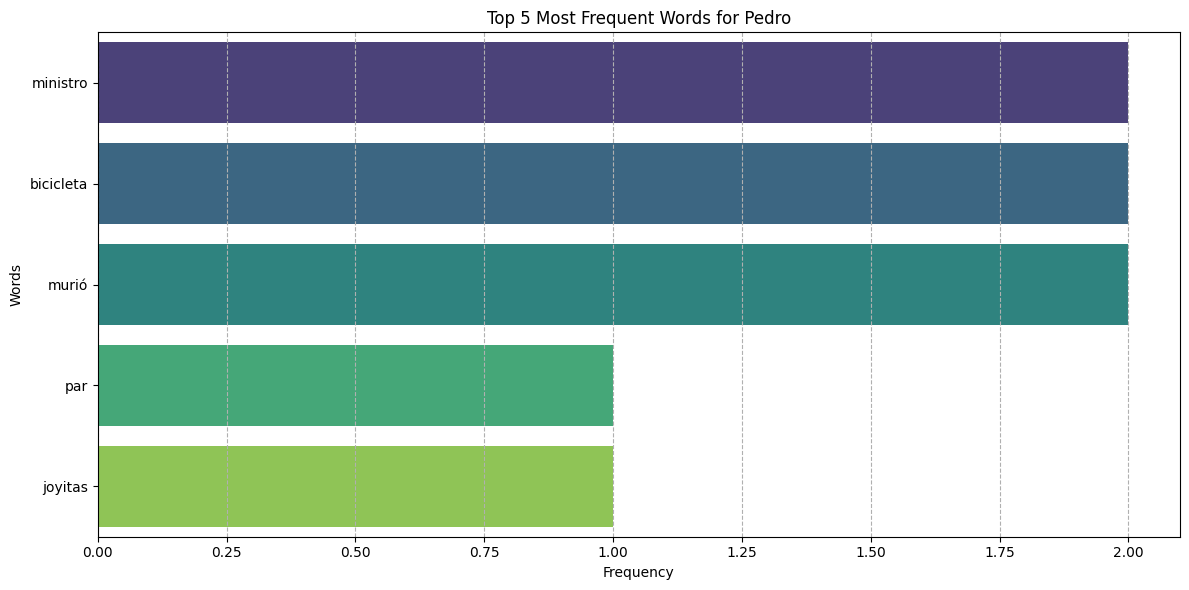

/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

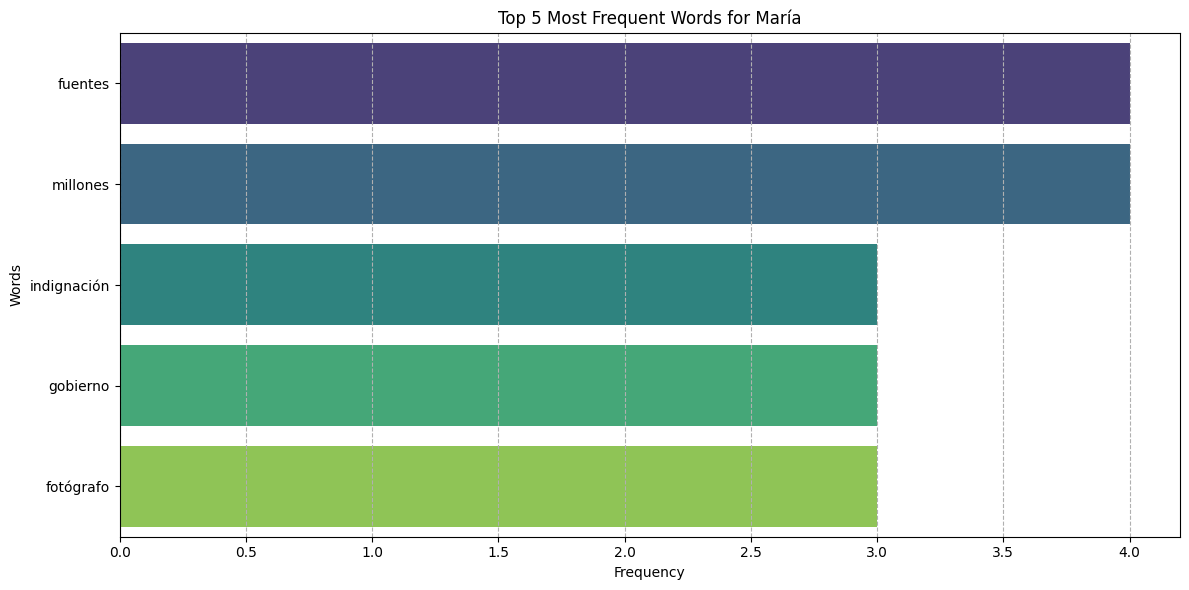

/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

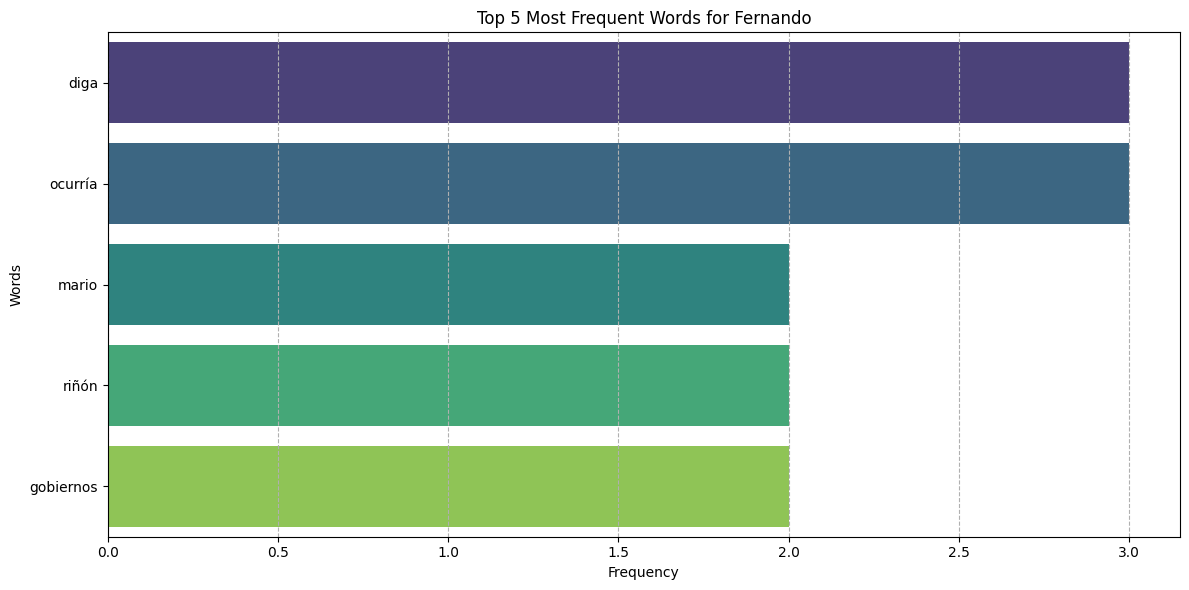

/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

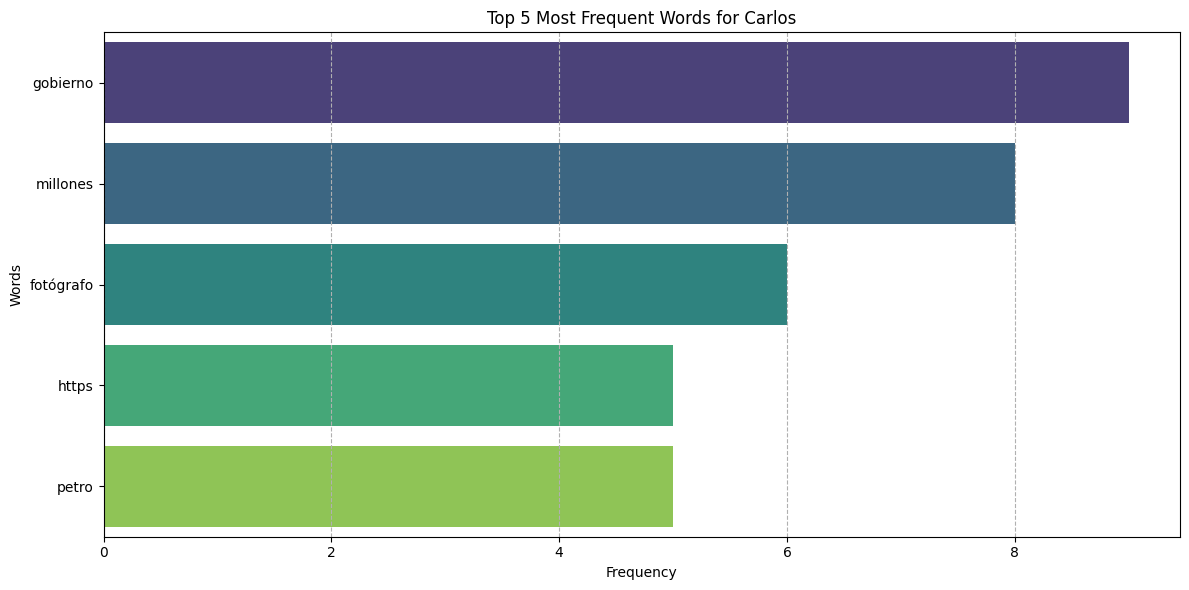

/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

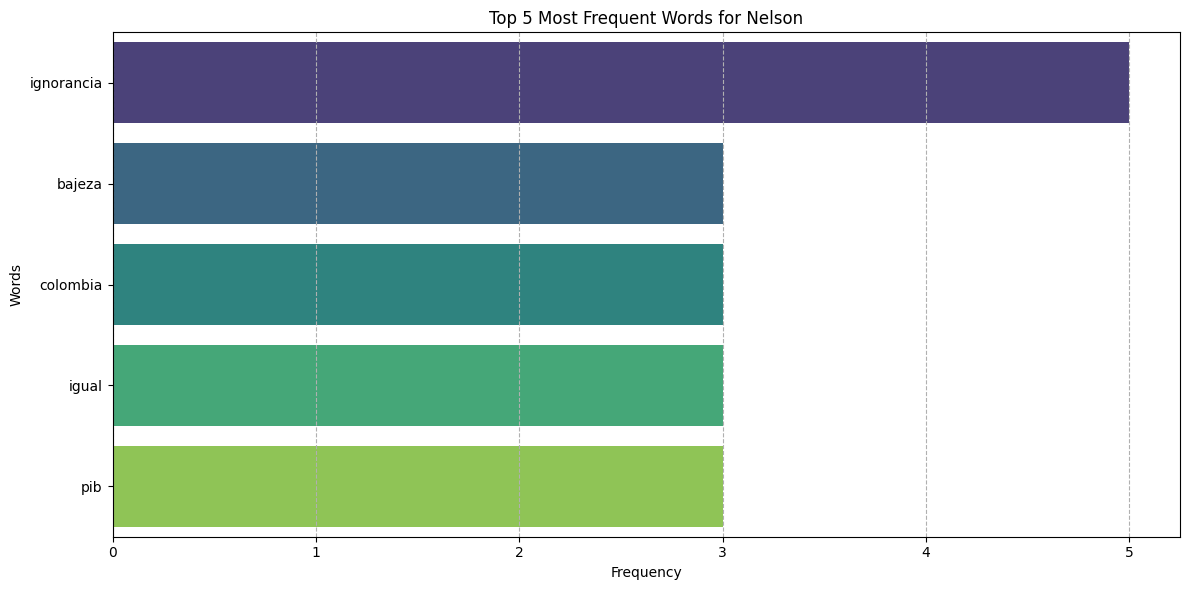

/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.12/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

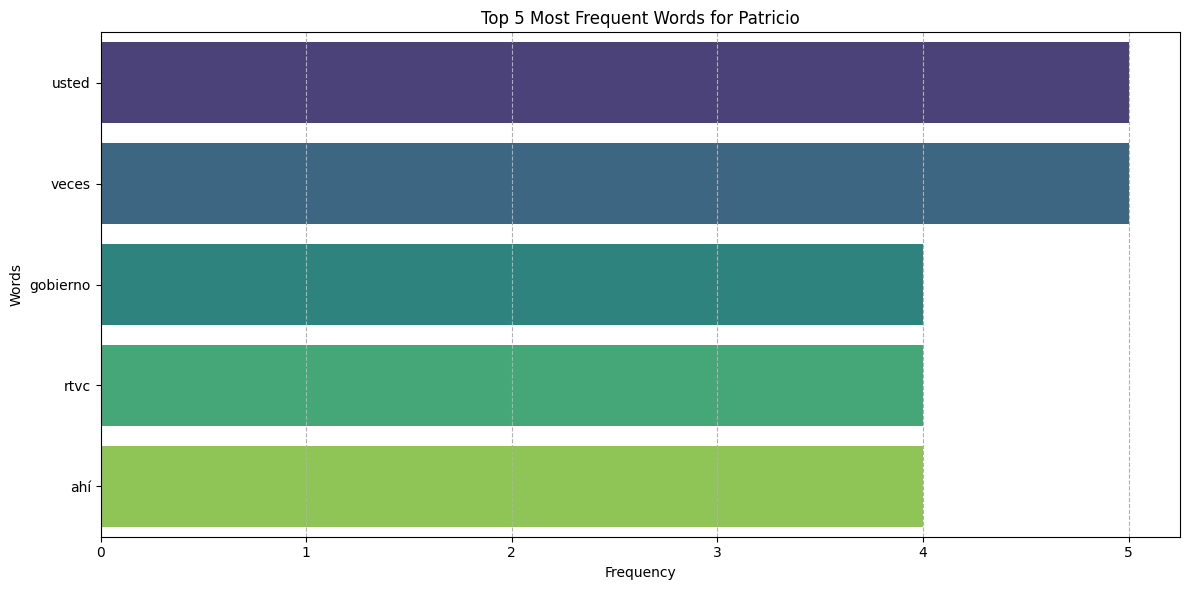

In [36]:
for participant, top_words in participant_top_words.items():
    words = [word for word, freq in top_words]
    frequencies = [freq for word, freq in top_words]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=frequencies, y=words, palette='viridis')
    plt.title(f'Top 5 Most Frequent Words for {participant}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

Pedro

	•	El vocabulario de Pedro parece centrarse en palabras como "ministro" y "bicicleta" y "murió", lo que podría indicar una discusión sobre un evento específico o una noticia relacionada con un ministro, una bicicleta y una muerte

María

	•	María utiliza con frecuencia palabras como "fuentes", "millones", "indignación", "gobierno" y "fotógrafo". Esto sugiere un discurso enfocado en la validación de la información, posiblemente discutiendo cifras financieras o gasto gubernamental, y refiriéndose quizá a un rol específico como el de “fotógrafo". La presencia de "indignación" apunta a comentarios críticos.

Fernando

	•	Las palabras más frecuentes de Fernando incluyen “diga", “ocurría", “mario", “riñón". Esto indica discusiones posiblemente centradas en reportes o declaraciones ("diga", “ocurría") relacionadas con temas de salud ("riñón") en el contexto de "gobiernos" o figuras políticas.

Carlos

	•	Las palabras más frecuentes de Carlos incluyen principalmente “gobierno", “millones", “fotógrafo". Esto apunta claramente a un enfoque en discusiones relacionadas con el gobierno, particularmente sobre gasto, contratos y roles específicos como “fotógrafo", posiblemente en relación con RTVC (un sistema de medios públicos). Se evidencia también la extracción de un token insignificante "https" que en este caso es una parte de las URLs que comparten en la conversación.

Nelson

	•	El vocabulario de Nelson se caracteriza por palabras como “ignorancia", “bajeza", “colombia", “igual", “pib". Esto sugiere un discurso más de opinión, abordando temas sociales e indicadores económicos.

Patricio

	•	Patricio utiliza palabras como “usted", “veces", “gobierno", "rtvc". Su comunicación parece centrarse en acciones gubernamentales o noticias (RTVC) posiblemente interactuando directamente con otros (“usted").

Observaciones Generales:

	•	Temas comunes: existe una coincidencia en temas políticos, con palabras como “gobierno" y “millones" que aparecen con frecuencia en varios participantes, lo que indica que la discusión gira principalmente en torno a la política y el gasto público.
	•	Controversias específicas: la palabra “fotógrafo" sugiere discusiones sobre algo posiblemente polémico, en las conversaciones de María y Carlos.
	•	Tono y participación: algunos participantes, como Nelson, muestran un tono más crítico y emocional (“ignorancia", “bajeza"), mientras que María se centra más en la precisión de los hechos (“fuentes").